In [94]:
import numpy as np
import math
import pandas as pd
from IPython.display import Image, display
from CoolProp.HumidAirProp import HAProps
import import_ipynb
import matplotlib.pyplot as plt
from PsychrometricProperty import W_ptr, Tdp_ptr, h_ptr, v_ptr, W_ptb,RH_ptb,Tdp_ptb,h_ptb,v_ptb,Tdp_ptW,h_ptw,RH_ptw,W_pth,RH_pth,T_pwh

### Example 1
A building space is to be maintained at $70°F$ and $35\%$ RH when outdoor design temperature is $10°F$. Design heat losses from the space are $250,000 Btu/hr$, sensible, and $45,000 Btu/h$, latent. Ventilation requires that $1500 cfm$ of outdoor air be used. Supply air is to be at $120°F$. Determine:\
a. the amount of supply air required, lbm/hr, and CFM.\
b. the capacity of the heating coil, Btu/hr, if\
    1).the humidifieier is a spray washer using circulated spray water with mackeup water provided at $60°F$\
    2). the humidifieier is a steam humidifier using saturated steam at $17.2 psia$.\
c. the capacity of the humidifier, lbm/hr.


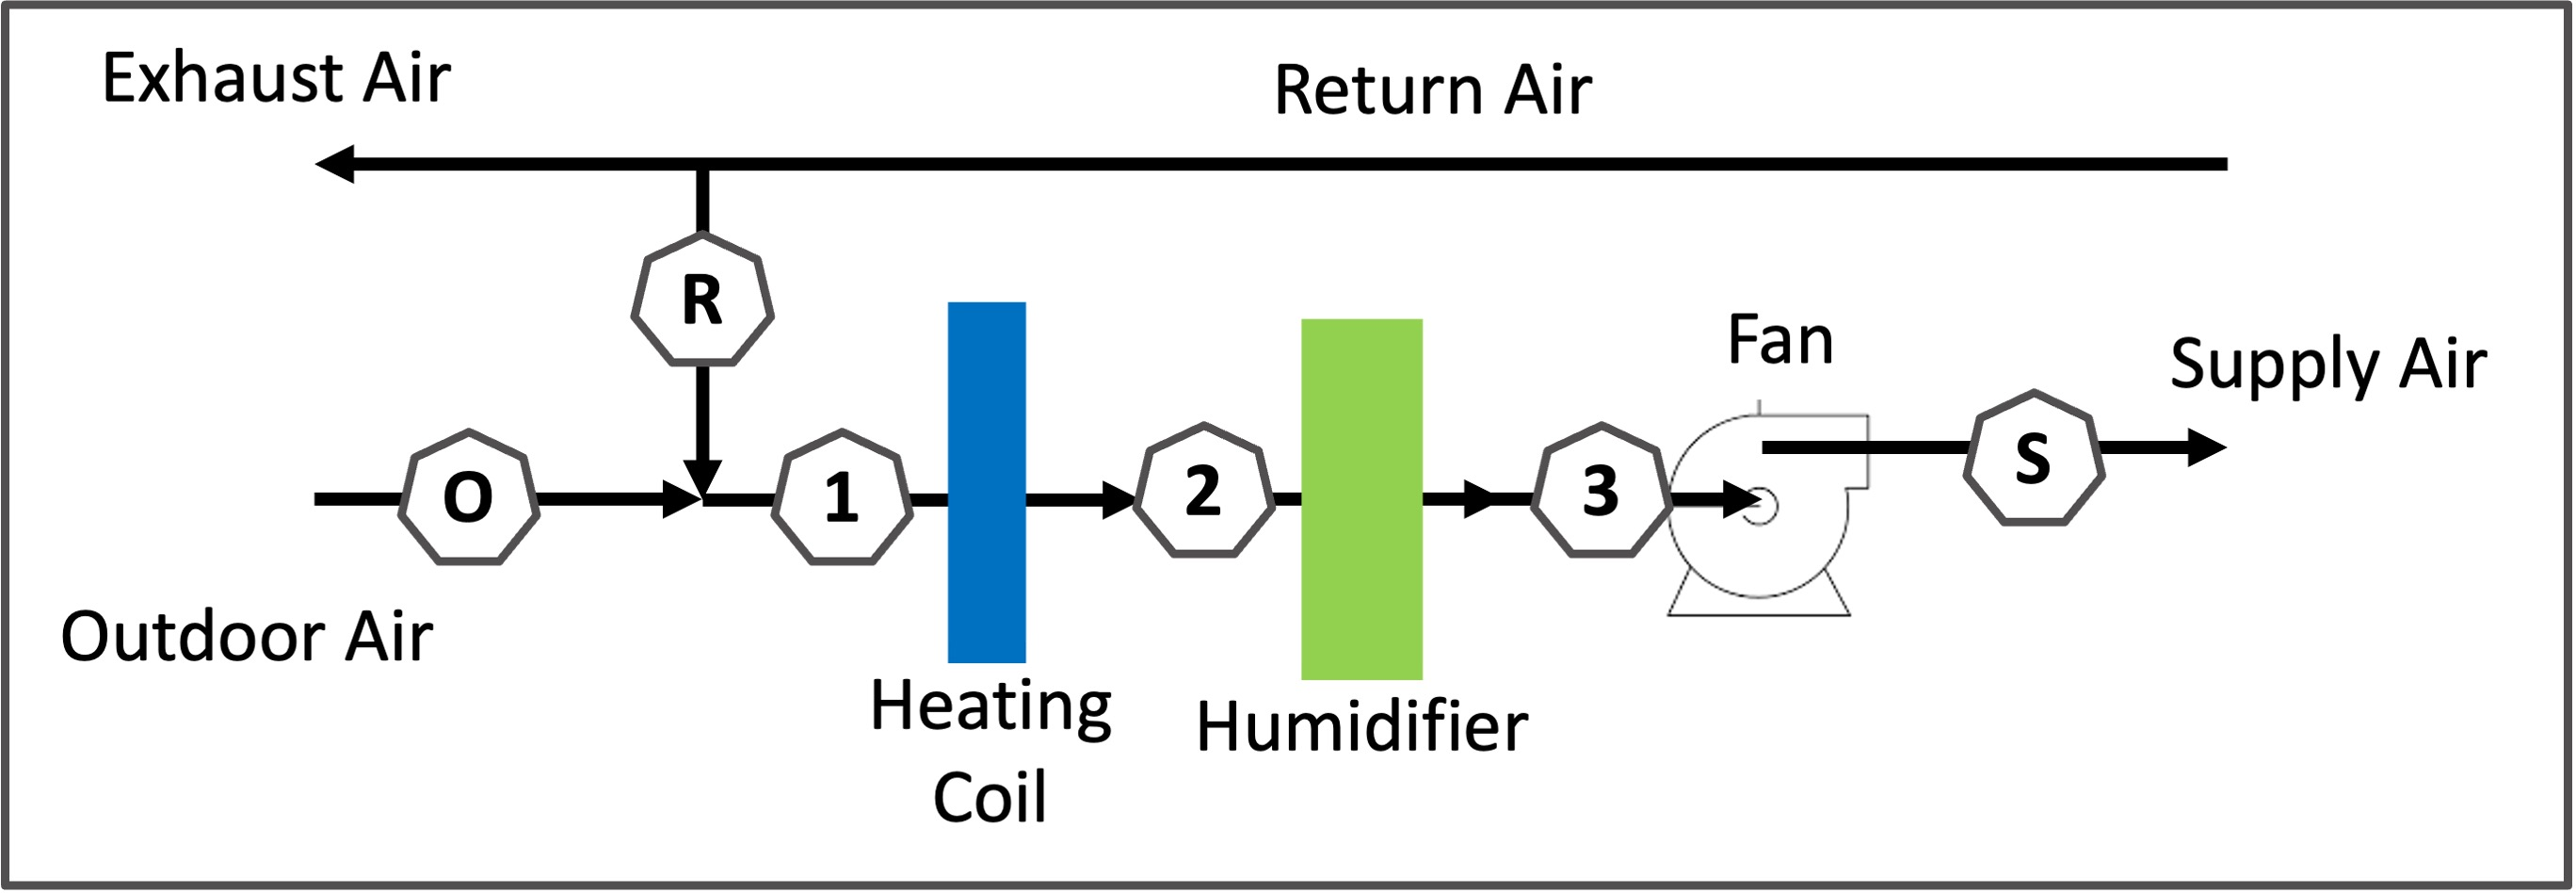

In [95]:
display(Image(filename='AirProcessing_E1.jpg')) 

In [96]:
P_atm = 14.7 # standard atmosphere pressure, [psi]
V_dot_ven = 1500 # the ventilation volume flow rate [cfm]
T_db_RA = 70 # return air drybulb temperature [F]
RH_RA = 35 # return air wetbulb temperature [F]
h_RA = h_ptr(P_atm,T_db_RA,RH_RA) # return air humidity ratio [Btu/lba]
w_RA = W_ptr(P_atm,T_db_RA,RH_RA) # return air humidity ratio [lb_w/lb_a]
v_RA = v_ptr(P_atm,T_db_RA,RH_RA) # return air specific volumn [ft3/lbm]

T_db_OA = 10 # return air drybulb temperature [F]
w_OA = 0
h_OA = h_ptr(P_atm,T_db_RA,0)


#### Step 1: to determine the amount of supply air
The supply air is delivered to the space changing from $120°F$ to $70°F$ to adress the sensible heating load in the space.  We can determine a point $x$ where the temperature of point is equal to the supply air temperature and the humidity ratio of $x$ is equal to that of the space air (return air), we can determine the enthalpy of point $x$ as follows:
$$h_x = @(P_{atm}, T_{db,SA}, w_{RA})$$
Based on the energy balance for space:
$$\dot{Q}_{sen,load} = \dot{m}_{SA} * (h_x - h_{RA})$$



In [97]:
Q_sen_load = 250000
T_db_SA = 115
h_x = h_ptw(P_atm,T_db_SA,w_RA) #calculate the enthalpy of point x
m_dot_SA = Q_sen_load/(h_x-h_RA)
V_dot_SA = m_dot_SA * v_RA/60
V_dot_cir = V_dot_SA - V_dot_ven
v_OA = 12.85
m_dot_ven = V_dot_ven/v_OA * 60
m_dot_cir = m_dot_SA - m_dot_ven
data = {
    "": ["Outdoor Air", "Recirculated Air", "Supply Air"],
    "Volume flow rate [CFM]": [f"{V_dot_ven:.2f}", f"{V_dot_cir:.2f}",f"{V_dot_SA:.2f}"],
    "Mass flow rate [lbm/hr]": [f"{m_dot_ven:.2f}", f"{m_dot_cir:.2f}",f"{m_dot_SA:.2f}"]
}
df = pd.DataFrame(data)
df

,,Volume flow rate [CFM],Mass flow rate [lbm/hr]
0,Outdoor Air,1500.00,7003.89
1,Recirculated Air,3642.55,15914.19
2,Supply Air,5142.55,22918.08


After we obtained the total mass flow rate of supply air, we can calculate the humidity of supply air based on the energy balance:
$$\dot{Q}_{lat,load} = \dot{m}_{SA} * (h_{SA} - h_{RA})$$
Thus:
$$h_{SA} = \frac{\dot{Q}_{lat,load}}{\dot{m}_{SA}} + h_{RA}$$
And we can obtain the humidity ratio.


In [98]:
Q_lat_load = 45000
Q_tot_load = Q_sen_load + Q_lat_load
h_SA = Q_tot_load/m_dot_SA + h_RA
w_SA = W_pth(P_atm, T_db_SA, h_SA) # humidity ratio of space air
RH_SA = RH_pth(P_atm, T_db_SA, h_SA) # relative humisity of space 5

data = {
    "State": ["Return Air", "Supply Air"],
    "T_db [F]": [f"{T_db_RA:.1f}",f"{T_db_SA:.1f}"],
    "RH [%]": [f"{RH_RA:.1f}",f"{RH_SA:.1f}"],
    "h [Btu/lba]": [f"{h_RA:.2f}", f"{h_SA:.2f}"],
    "w[lbw/lba]": [f"{w_RA:.4f}", f"{w_SA:.4f}"]
}
df = pd.DataFrame(data)
df

,State,T_db [F],RH [%],h [Btu/lba],w[lbw/lba]
0,Return Air,70.0,35.0,22.73,0.0054
1,Supply Air,115.0,11.4,35.60,0.0072


#### Step 2. Determine the state 1 after mixing the return air and ventilation (outdoor) air:
For the mixing point, based on the mass balance of the mositure:
$$\dot{m}_{ven} w_{OA} + \dot{m}_{cir} w_{RA} = \dot{m}_{SA} w_{1}$$
Based on the energy balance:
$$\dot{m}_{ven} h_{OA} + \dot{m}_{cir} h_{RA} = \dot{m}_{SA} h_{1}$$
Thus, the humidity ratio is:
$$w_{1} = \frac{\dot{m}_{ven} w_{OA} + \dot{m}_{cir} w_{RA}}{\dot{m}_{SA}}$$
the enthalpy is: 
$$h_{1} = \frac{\dot{m}_{ven} h_{OA} + \dot{m}_{cir} h_{RA}}{\dot{m}_{SA}}$$

In [99]:
w_1 = (m_dot_ven * w_OA + m_dot_cir * w_RA)/m_dot_SA # humidity ratio at state 3, [lbw/lba]
h_1 = (m_dot_ven * h_OA + m_dot_cir * h_RA)/m_dot_SA # enthalpy at state 3, [Btu/lba]
T_db_1 = T_pwh(P_atm, w_1, h_1) # dry-bulb at state 3, F
RH_1 = RH_ptw(P_atm, T_db_1, w_1) # relative humidity at state 3, %

#### Step 3. Determine the capacity of the humidifier
Since no mositure is added in or removed out from 1-2 and 3-SA, thus:
$$w_{1} = w_2; w_3 = w_{SA}$$
$$H = \dot{m}_{SA} (w_{3}-w_2) = \dot{m}_{SA} (w_{SA}-w_1)$$

In [100]:
H = m_dot_SA * (w_SA-w_1)

#### Step 3. Determine the capacity of the heating coil
Include the humidifier in the control volume and based on the energy balance:
$$\dot{m}_{SA} h_2 + \dot{m}_{SA} (w_3-w_2)h_w = \dot{m}_{SA} h_3$$
thus:
$$h_2 = h_3 - (w_3-w_2)h_w $$
Case 1: If the humidifieier is a spray washer using circulated spray water with mackeup water provided at $60°F$.To find the h_s in Table below: 
$$h_w = 28.08 [Btu/lbm]$$
Case 2: If the humidifieier is a steam humidifier using saturated steam at $17.2 psia$.
$$h_s = 1153.3 [Btu/lbm]$$
The capacity of the heating coil is:
$$\dot{Q}_{heating} = \dot{m}_{SA} (h_2-h_1)$$


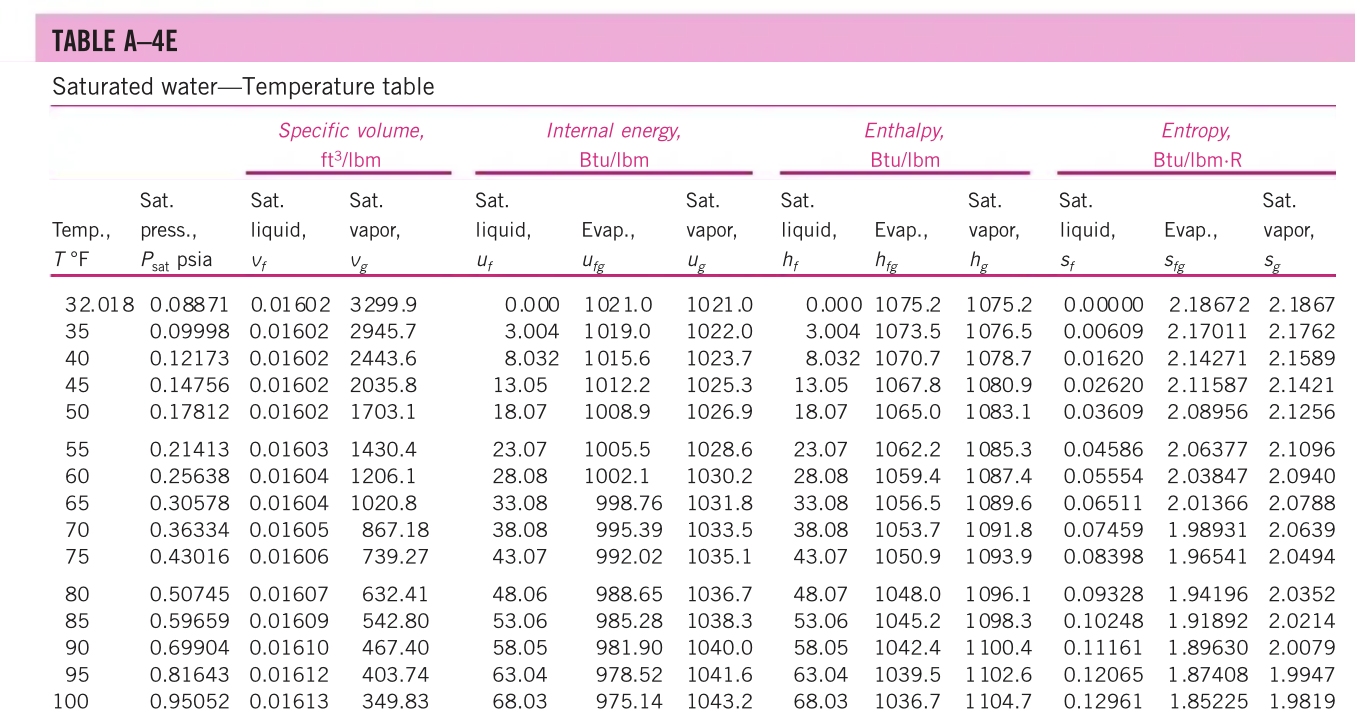

In [101]:
w_2 = w_1
h_w_1 = 28.08
h_2 = h_SA - (w_SA - w_1)*h_w_1
T_db_2 = T_pwh(P_atm, w_2, h_2) # dry-bulb at state 3, F
RH_2 = RH_ptw(P_atm, T_db_2, w_2) # relative humidity at state 3, %
display(Image(filename='SaturatedWaterTable.jpg')) 

In [102]:
data = {
    "State": ["State 1", "State 2", "State 3"],
    "T_db [F]": [f"{T_db_1:.1f}",f"{T_db_2:.1f}",f"{T_db_SA:.1f}"],
    "RH [%]": [f"{RH_1:.1f}",f"{RH_2:.1f}",f"{RH_SA:.1f}"],
    "h [Btu/lba]": [f"{h_1:.2f}", f"{h_2:.2f}",f"{h_SA:.2f}"],
    "w[lbw/lba]": [f"{w_1:.4f}", f"{w_2:.4f}",f"{w_SA:.4f}"]
}
df = pd.DataFrame(data)
df

,State,T_db [F],RH [%],h [Btu/lba],w[lbw/lba]
0,State 1,70.0,24.4,20.92,0.0038
1,State 2,130.4,3.9,35.50,0.0038
2,State 3,115.0,11.4,35.60,0.0072


In [ ]:
Q_dot_heating_1 = m_dot_SA * (h_2-h_1)

The capacity of heating coil is  334302.2 Btu/hr


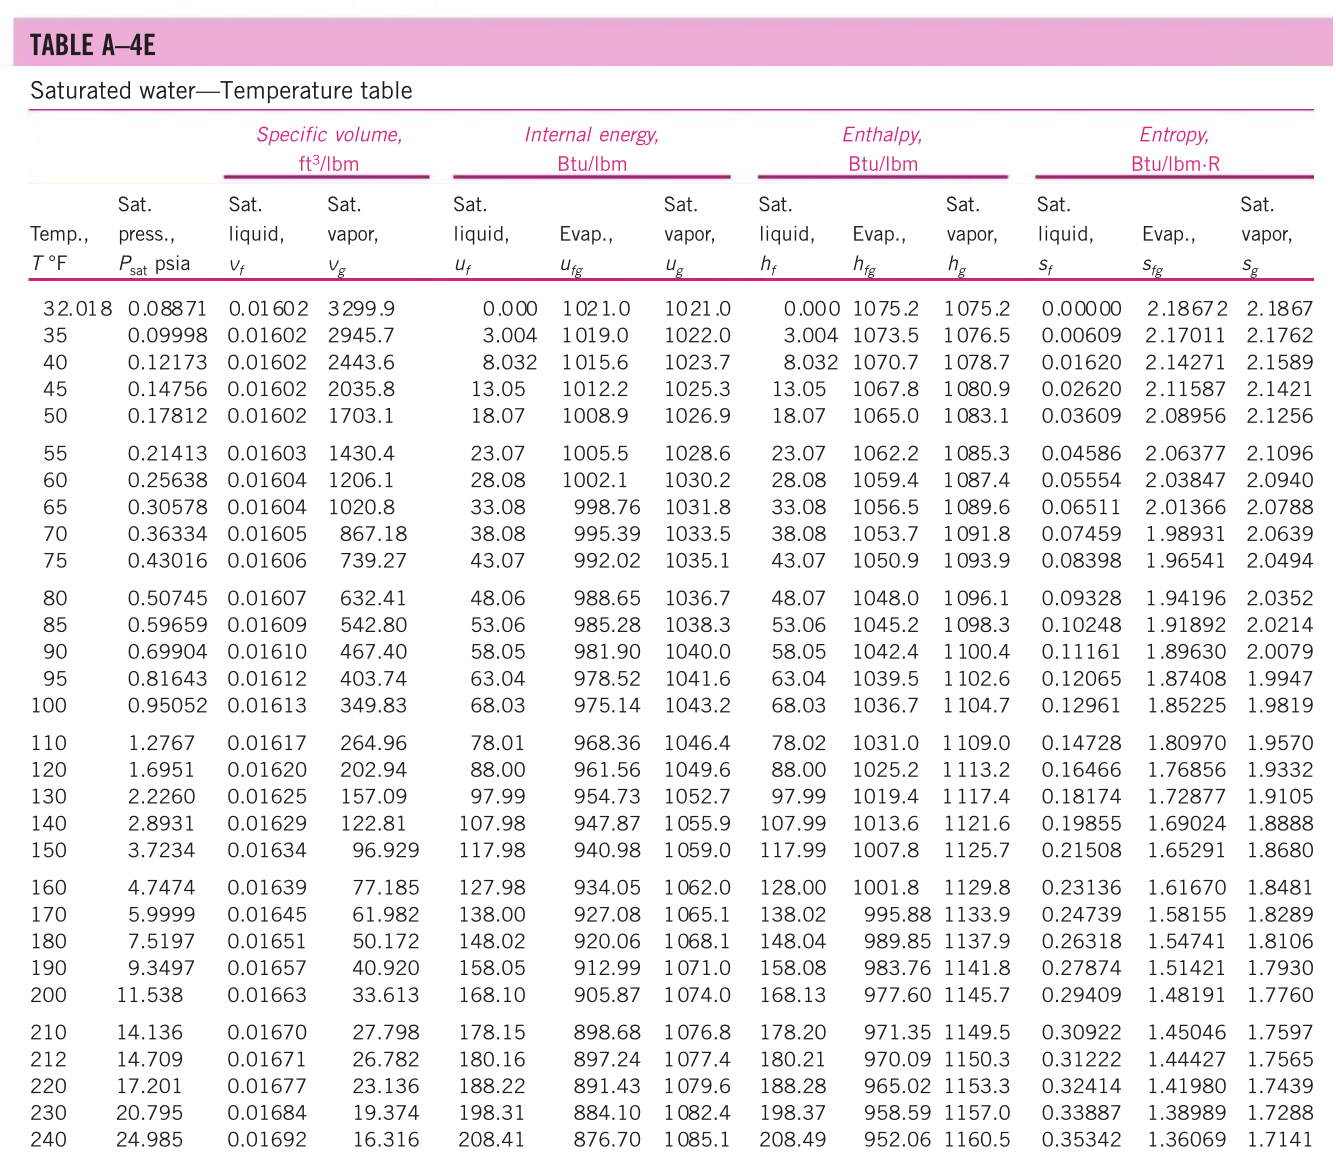

In [104]:
display(Image(filename='SaturatedSteamTable.jpg')) 

In [105]:
w_2 = w_1
h_w_2 = 1153.3
h_2 = h_SA - (w_SA - w_1)*h_w_2
T_db_2 = T_pwh(P_atm, w_2, h_2) # dry-bulb at state 3, F
RH_2 = RH_ptw(P_atm, T_db_2, w_2) # relative humidity at state 3, %
data = {
    "State": ["State 1", "State 2", "State 3"],
    "T_db [F]": [f"{T_db_1:.1f}",f"{T_db_2:.1f}",f"{T_db_SA:.1f}"],
    "RH [%]": [f"{RH_1:.1f}",f"{RH_2:.1f}",f"{RH_SA:.1f}"],
    "h [Btu/lba]": [f"{h_1:.2f}", f"{h_2:.2f}",f"{h_SA:.2f}"],
    "w[lbw/lba]": [f"{w_1:.4f}", f"{w_2:.4f}",f"{w_SA:.4f}"]
}
df = pd.DataFrame(data)
df

,State,T_db [F],RH [%],h [Btu/lba],w[lbw/lba]
0,State 1,70.0,24.4,20.92,0.0038
1,State 2,114.4,6.1,31.65,0.0038
2,State 3,115.0,11.4,35.60,0.0072


In [ ]:
Q_dot_heating_2 = m_dot_SA * (h_2-h_1)

data = {"Cases": ["Case 1", "Case 2"],
        "The capacity of heating coil [Btu/hr]": [f"{Q_dot_heating_1:.1f}",f"{Q_dot_heating_2:.1f}"]
}
df = pd.DataFrame(data)
df

,Cases,The capacity of heating coil [Btu/hr]
0,Case 1,334302.2
1,Case 2,246004.5


In [108]:
print("The capacity of humidifier is ", f"{H:.1f}",'lbm/hr')

The capacity of humidifier is  78.5 lbm/hr
